In [180]:
from collections import OrderedDict

import os

import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import pandas as pd
import numpy as np
from PIL import Image
import time
from IPython.display import display
import shutil

import cv2


%load_ext autoreload

%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset_file = pd.read_csv("../data/final_dataset.csv")
dataset_file.head()

sequence image_sequence                      file label  site  \
0         2         image1  290716114012001a1116.JPG  BIRD  001a   
1        12         image1  100816090812001a1111.JPG  BIRD  001a   
2        17         image1  180516121622001a1602.JPG  BIRD  001a   
3        18         image1  260416120224001a1601.JPG  BIRD  001a   
4        20         image1  160516023810001a1606.JPG   CAT  001a   

              date camera  sequence_image_count  has_animal    set  
0  7/29/2016 11:40    111                     3           1  train  
1   8/10/2016 9:08    111                     3           1  train  
2  5/18/2016 12:16    160                     3           1  train  
3  4/26/2016 12:02    160                     3           1  train  
4   5/16/2016 2:38    160                     3           1   test

In [4]:
dataset_file['time'] = pd.to_datetime(dataset_file.date).dt.time

In [5]:
train_subset = dataset_file[dataset_file.set == 'train']
background_subset = train_subset[train_subset.has_animal == 0]

In [6]:
cam_loc_1 = background_subset[((background_subset.camera == '111') & (background_subset.site=='001a'))]

In [7]:
(background_subset.groupby(['site', 'camera']).count()//3).reset_index()

site camera  sequence  image_sequence  file  label  date  \
0    001a    111        69              69    69     69    69   
1    001a    160         1               1     1      1     1   
2    001a    s07         3               3     3      3     3   
3    001a    s46        19              19    19     19    19   
4    001b    923        14              14    14     14    14   
..    ...    ...       ...             ...   ...    ...   ...   
603   956    590        31              31    31     31    31   
604   956    L17         8               8     8      8     8   
605   985    330        18              18    18     18    18   
606   985    S18        14              14    14     14    14   
607   985    S35         4               4     4      4     4   

     sequence_image_count  has_animal  set  time  
0                      69          69   69    69  
1                       1           1    1     1  
2                       3           3    3     3  
3                      19          19   19    19  
4                      14          14   14    14  
..                    ...         ...  ...   ...  
603                    31          31   31    31  
604                     8           8    8     8  
605                    18          18   18    18  
606                    14          14   14    14  
607                     4           4    4     4  

[608 rows x 11 columns]

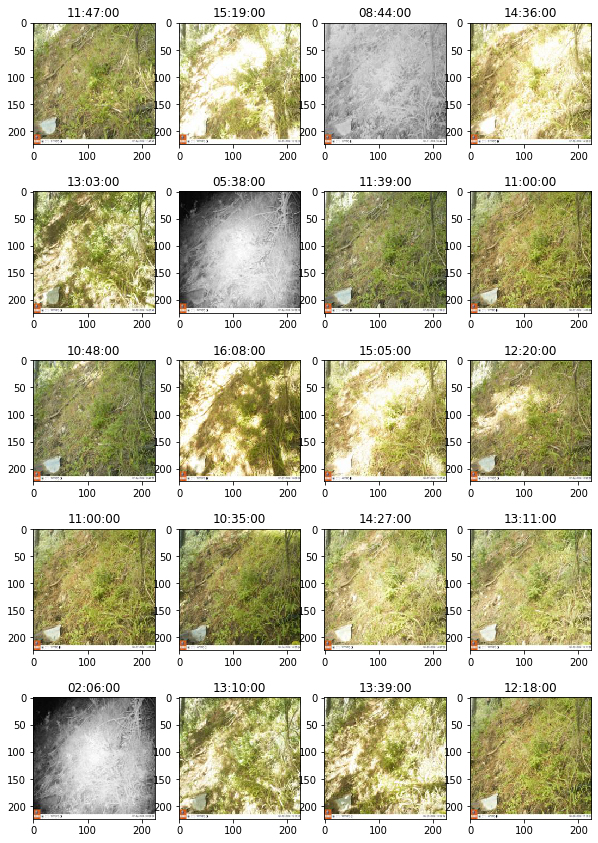

In [9]:
plt.figure(figsize=(10, 15))
for idx, filename in cam_loc_1.sample(20).reset_index(drop=True).iterrows():
    ax = plt.subplot(5, 4, idx + 1)
    plt.imshow(imread(os.path.join('../data/images-resized-224/', filename.file)))
    plt.title(filename.time)

### Site camera combo analysis

In [10]:
all_site_cam_combo = list(set(map(lambda a: (a[0], a[1]), train_subset[['site', 'camera']].values)))

039a s22
96
(224, 224, 3)


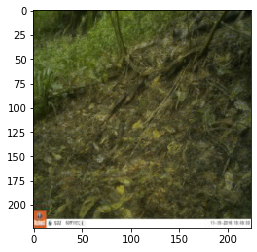

In [12]:
for site, camera in all_site_cam_combo:
    print(site, camera)
    background_list = train_subset[(train_subset.site == site) & 
                                        (train_subset.camera == camera) & 
                                        (train_subset.has_animal == 0)]
    images = []
    print(len(background_list))
    for filename in background_list.file:
        images.append(imread(os.path.join('../data/images-resized-224/', filename)))
        
    median_image = np.median(np.array(images), axis=0).astype(np.int32)
    print(median_image.shape)
    plt.imshow(median_image)
    break

### Simple background differencing

In [13]:
train_subset.head()

sequence image_sequence                      file label  site  \
0         2         image1  290716114012001a1116.JPG  BIRD  001a   
1        12         image1  100816090812001a1111.JPG  BIRD  001a   
2        17         image1  180516121622001a1602.JPG  BIRD  001a   
3        18         image1  260416120224001a1601.JPG  BIRD  001a   
5        22         image1  100516120628001a1604.JPG  BIRD  001a   

              date camera  sequence_image_count  has_animal    set      time  
0  7/29/2016 11:40    111                     3           1  train  11:40:00  
1   8/10/2016 9:08    111                     3           1  train  09:08:00  
2  5/18/2016 12:16    160                     3           1  train  12:16:00  
3  4/26/2016 12:02    160                     3           1  train  12:02:00  
5  5/10/2016 12:06    160                     3           1  train  12:06:00

In [14]:
def get_pivoted_subset(data, subset):
    subset_data = data.loc[data.set == subset]
    pivoted_data = subset_data.pivot(index='sequence', 
                                     columns='image_sequence', 
                                     values='file').reset_index()
    pivoted_data.columns.name = None
    label_mapper = data[['sequence', 'has_animal']].drop_duplicates('sequence')\
                   .set_index('sequence').to_dict()['has_animal']
    pivoted_data['has_animal'] = pivoted_data.sequence.map(label_mapper.get)
    return pivoted_data

In [15]:
pivoted_train_data = get_pivoted_subset(train_subset, 'train')
# pivoted_train_data = pivoted_train_data[pivoted_train_data.has_animal == 1].reset_index(drop=True)
pivoted_train_data.head()

sequence                    image1                    image2  \
0         2  290716114012001a1116.JPG  290716114014001a1114.JPG   
1         3  280716130614001a1111.JPG  280716130614001a1112.JPG   
2         4  280716130526001a1113.JPG  280716130528001a1111.JPG   
3         5  250716162756001a1113.JPG  250716162758001a1111.JPG   
4         6  250716130638001a1113.JPG  250716130640001a1111.JPG   

                     image3  has_animal  
0  290716114014001a1115.JPG           1  
1  280716130614001a1113.JPG           0  
2  280716130528001a1112.JPG           0  
3  250716162758001a1112.JPG           0  
4  250716130640001a1112.JPG           0

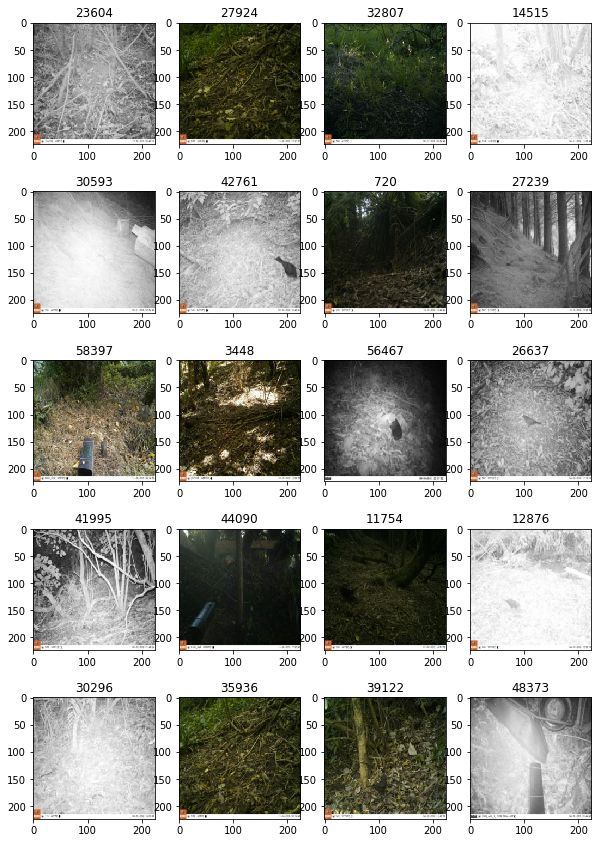

In [16]:
plt.figure(figsize=(10, 15))
for idx, filename in pivoted_train_data.sample(20).reset_index().iterrows():
    ax = plt.subplot(5, 4, idx + 1)
    plt.imshow(imread(os.path.join('../data/images-resized-224/', filename.image1)))
    plt.title(str(filename['index']))

In [17]:
pivoted_train_data.reset_index().head()

index  sequence                    image1                    image2  \
0      0         2  290716114012001a1116.JPG  290716114014001a1114.JPG   
1      1         3  280716130614001a1111.JPG  280716130614001a1112.JPG   
2      2         4  280716130526001a1113.JPG  280716130528001a1111.JPG   
3      3         5  250716162756001a1113.JPG  250716162758001a1111.JPG   
4      4         6  250716130638001a1113.JPG  250716130640001a1111.JPG   

                     image3  has_animal  
0  290716114014001a1115.JPG           1  
1  280716130614001a1113.JPG           0  
2  280716130528001a1112.JPG           0  
3  250716162758001a1112.JPG           0  
4  250716130640001a1112.JPG           0

(224, 224, 4)


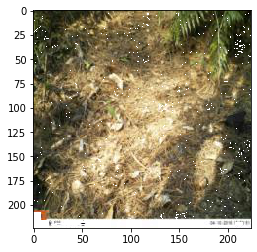

In [23]:
def get_difference_image(data_row):
    img1 = imread(os.path.join("../data/images-resized-224/", data_row.image1))
    img2 = imread(os.path.join("../data/images-resized-224/", data_row.image2))
    img3 = imread(os.path.join("../data/images-resized-224/", data_row.image3))
    
    diff12 = np.isclose(img1, img2)
    diff13 = np.isclose(img1, img3)
    diff23 = np.isclose(img2, img3)
    
    diff_img = np.logical_and(diff12, diff13, diff23)
    
#     diff_img = np.logical_and(img1 == img2, img2 == img3, img1 == img3)
    diff_img = np.logical_not(np.logical_and(diff_img[:, :, 0], 
                                             diff_img[:, :, 1], 
                                             diff_img[:, :, 2])).astype(np.uint8) * 255
    diff_img = np.dstack((img1, diff_img))
    print(diff_img.shape)
    plt.imshow(diff_img)
#     plt.imshow(img2)
    
    
get_difference_image(pivoted_train_data.loc[43756])

### GMM

In [259]:
def get_mask(data_row):
    img1 = imread(os.path.join("../data/images-resized-224//", data_row.image1))
    img2 = imread(os.path.join("../data/images-resized-224/", data_row.image2))
    img3 = imread(os.path.join("../data/images-resized-224/", data_row.image3))

    fgbg = cv2.createBackgroundSubtractorMOG2()

    frames = [img1, img2, img3]

    for frame in frames:
        fgmask = fgbg.apply(frame)
    
    return fgmask

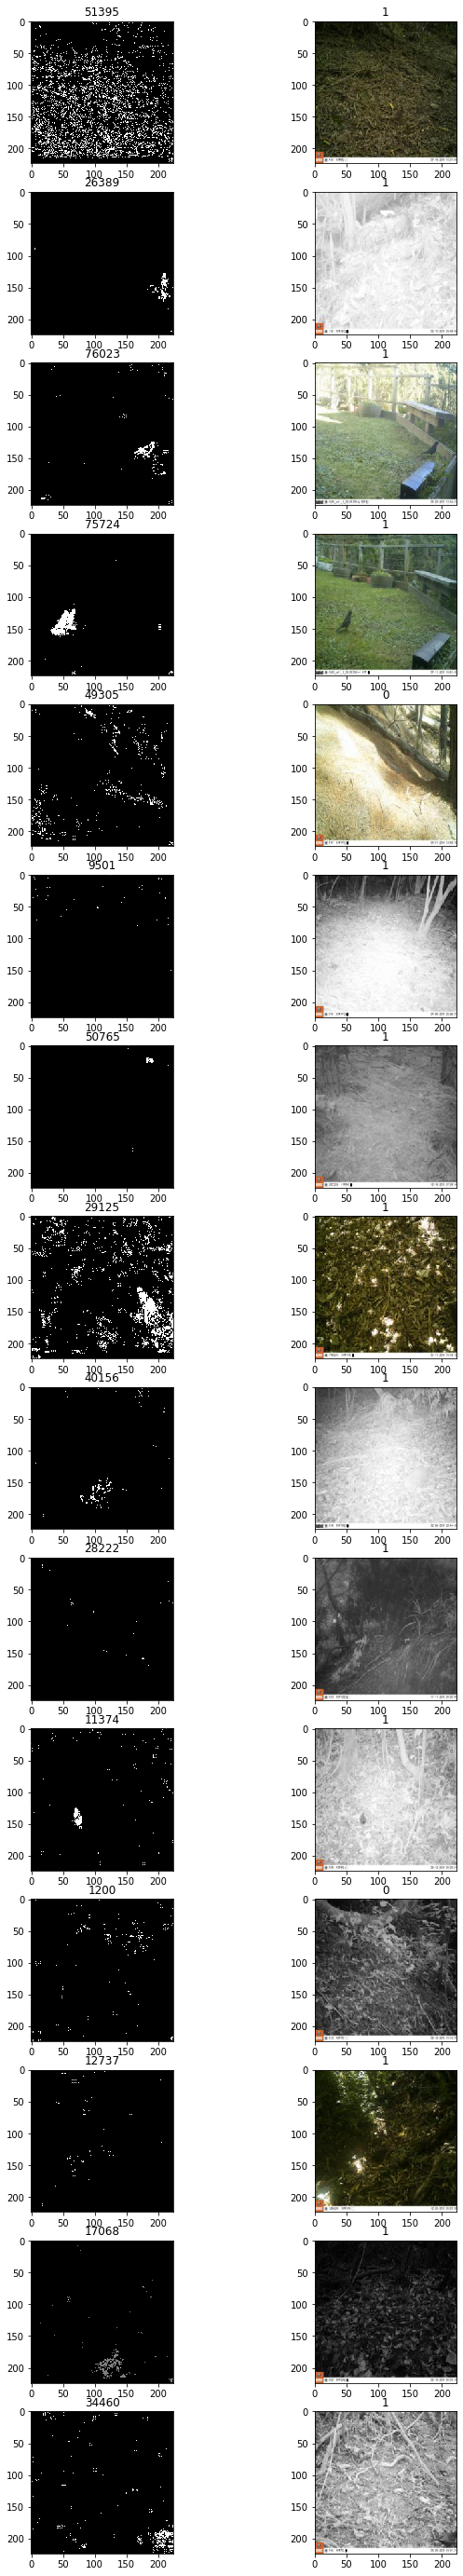

In [260]:
ref_dict = OrderedDict()
outdir = "../data/sequence_observation"

plt.figure(figsize=(10, 50))
for idx, filename in pivoted_train_data.sample(15, random_state=2).reset_index().iterrows():
    ax = plt.subplot(15, 2, (2 * idx) + 1)
    plt.imshow(get_mask(filename), cmap='gray')
    plt.title(str(filename['sequence']))
    ax = plt.subplot(15, 2, 2 * (idx + 1))
    plt.imshow(imread(os.path.join('../data/images-resized-224/', filename.image1)))
    ref_dict[filename.sequence] = ([filename.image1, filename.image2, filename.image3], filename["has_animal"], filename)
    plt.title(str(filename['has_animal']))

for seq_id, image_names_label_filename in ref_dict.items():
    image_names, label, filename = image_names_label_filename
    for i, x in enumerate(image_names):
        shutil.copy(os.path.join("../data/images-resized-224", x), os.path.join(outdir, "%s_%s-%s.JPG" % (seq_id, i+1, label)))


### Dense Optical Flow (Gunner Farneback’s Algorithm)

In [261]:
def get_flow_rgb_images(sequence_frame_names, flag=cv2.OPTFLOW_FARNEBACK_GAUSSIAN):
    """
    Compute Dense Optical Flow using Gunner Farneback’s algorithm (BGR velocity image)
    computed from prev_frame and current_frame.

    sequence_frame_names: List of the paths to the frames belonging to a sequence of images.
    flag: Chose from [0, cv2.OPTFLOW_USE_INITIAL_FLOW, cv2.OPTFLOW_FARNEBACK_GAUSSIAN].
    Default: cv2.OPTFLOW_FARNEBACK_GAUSSIAN.

    Returns: (average_flow_rgb_image, list_of_all_flow_rgb_images)
    Note: The list_of_all_flow_rgb_images contains 'n-1' images if sequence_frame_names
    contains 'n' images.

    """
    # Initialize the first frame as reference frame.
    prev_frame = cv2.imread(sequence_frame_names[0])
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    # Placeholders to store flow_rgb images and average flow_rgb image.
    flow_rgb_images = []
    avg_flow_rgb = np.zeros_like(prev_frame)
    num_flows = len(sequence_frame_names) - 1  # There will be 1 less flow image as first image is a reference image.

    # Initialize HSV image to store and convert flow output to RGB image.
    hsv = np.zeros_like(prev_frame)
    hsv[..., 1] = 255

    # Produce flow_output_rgb images.
    for current_frame_name in sequence_frame_names[1:]:
        current_frame_gray = cv2.cvtColor(cv2.imread(current_frame_name), cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, current_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, flag)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[..., 0] = ang*180/np.pi/2
        hsv[..., 2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        cur_flow_rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)  # Actually BGR (not RGB) but essentially same information.

        flow_rgb_images.append(cur_flow_rgb)
        avg_flow_rgb = avg_flow_rgb + (cur_flow_rgb / num_flows)

        prev_frame_gray = current_frame_gray

    # Round off the average flow rgb image.
    avg_flow_rgb = np.array(np.round(avg_flow_rgb), dtype=np.uint8)

    return avg_flow_rgb, flow_rgb_images


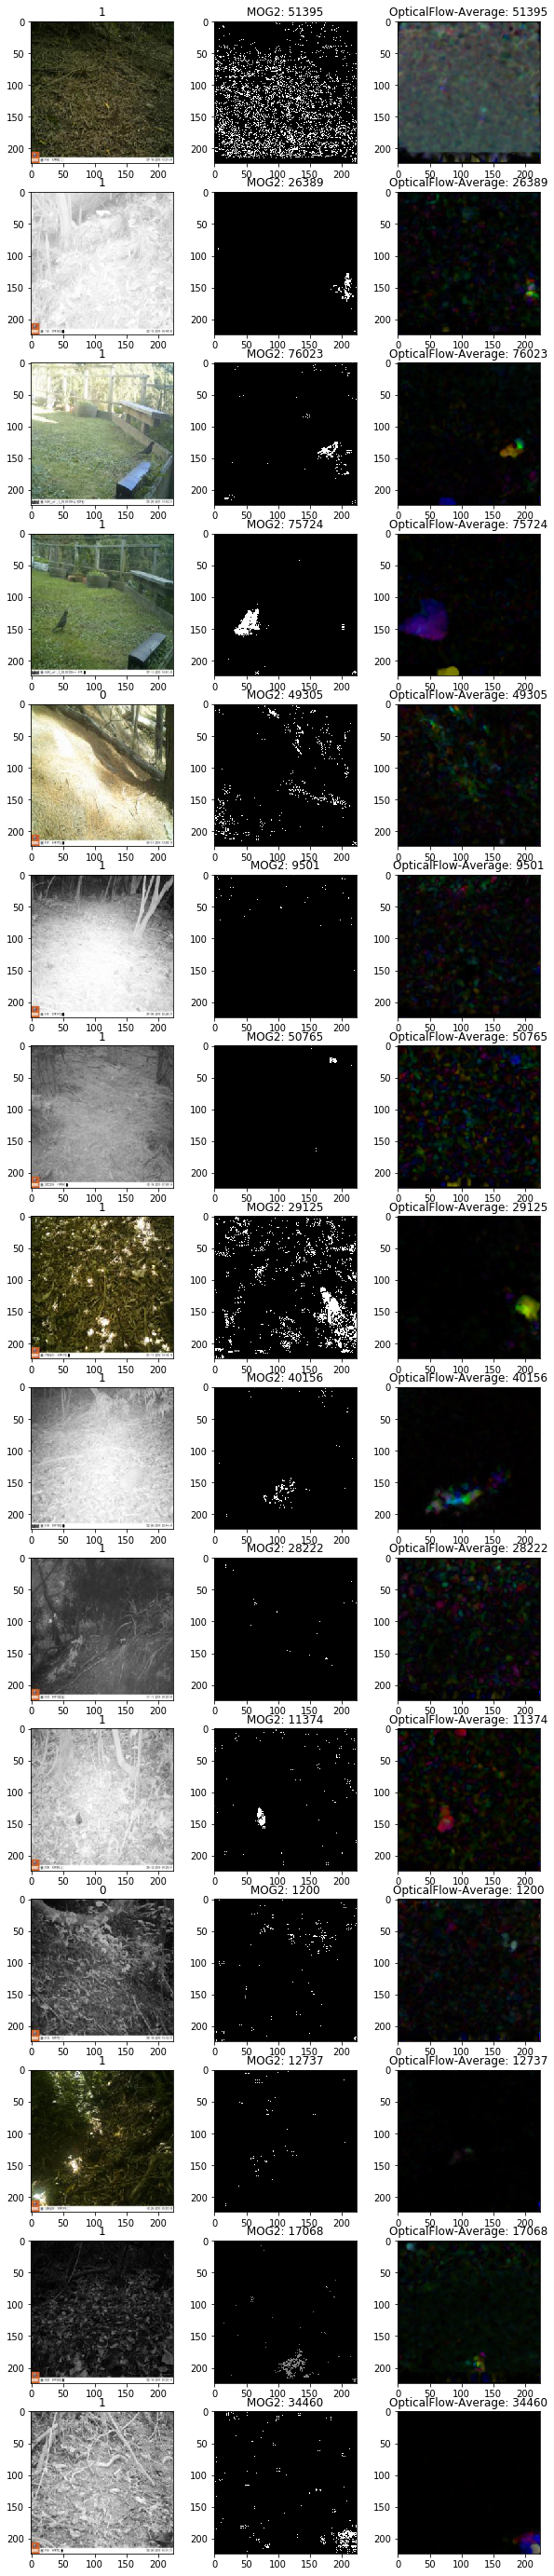

In [266]:
plt.figure(figsize=(10, 50))
idx = 0
for seq_id, images_label_filename in ref_dict.items():
    images, label, filename = images_label_filename
    image_names = [os.path.join('../data/images-resized-224/', x) for x in images]

    # First image.
    ax = plt.subplot(15, 3, (3 * idx) + 1)
    plt.imshow(imread(image_names[0]))
    plt.title(label)

    # Background subtraction.
    ax = plt.subplot(15, 3, (3 * idx) + 2)
    plt.imshow(get_mask(filename), cmap='gray')
    plt.title("MOG2: %s" % seq_id)

    # Optical Flow Average.
    avg_flow_image, flow_images = get_flow_rgb_images(image_names, flag=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    ax = plt.subplot(15, 3, (3 * idx) + 3)
    plt.imshow(avg_flow_image)
    plt.title("OpticalFlow-Average: %s" % seq_id)

    idx += 1


### Try Dense Optical Flow

In [51]:
# The above sequence images are stored in "ref_dict".

In [218]:
def _get_flow_rgb(prev_frame, current_frame, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN):
    """
    Return Dense Optical Flow using Gunner Farneback’s algorithm (BGR velocity image)
    computed from prev_frame and current_frame.
    Flags: 0, cv2.OPTFLOW_USE_INITIAL_FLOW, cv2.OPTFLOW_FARNEBACK_GAUSSIAN.

    """
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(prev_frame)
    hsv[...,1] = 255
    flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, current_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, flags)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    return rgb


In [220]:
seq_id = 29125
images, label = ref_dict[seq_id]
frame1_name = os.path.join("../data/images-resized-224", images[0])
frame1 = cv2.imread(os.path.join("../data/images-resized-224", images[0]))
frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

frame2_name = os.path.join("../data/images-resized-224", images[1])
frame2 = cv2.imread(os.path.join("../data/images-resized-224", images[1]))
frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

frame3_name = os.path.join("../data/images-resized-224", images[2])
frame3 = cv2.imread(os.path.join("../data/images-resized-224", images[2]))
frame3_gray = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)

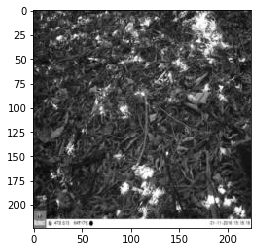

In [221]:
plt.imshow(frame1_gray, cmap="gray")

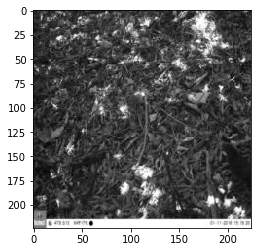

In [222]:
plt.imshow(frame2_gray, cmap="gray")

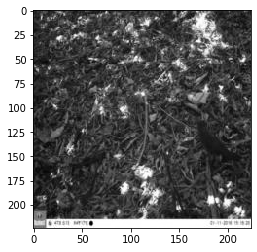

In [223]:
plt.imshow(frame3_gray, cmap="gray")

Time taken: 0.01


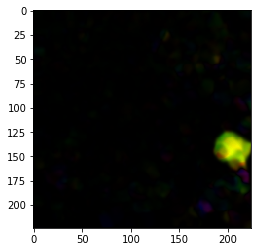

In [241]:
t1 = time.time()
flow_rgb_1 = _get_flow_rgb(frame1, frame2, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
t2 = time.time()
plt.imshow(flow_rgb_1)
print("Time taken: %.2f" % (t2 - t1))

Time taken: 0.01


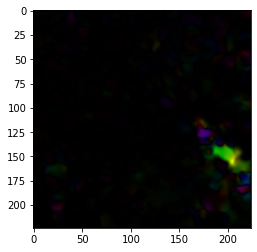

In [242]:
t1 = time.time()
flow_rgb_2 = _get_flow_rgb(frame2, frame3, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
t2 = time.time()
plt.imshow(flow_rgb_2)
print("Time taken: %.2f" % (t2 - t1))

In [226]:
# Merging the optical flows using Average.

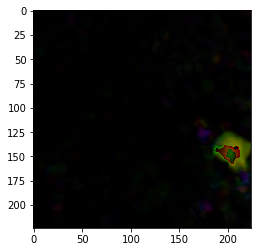

In [243]:
avg_img_1 = (flow_rgb_1 + flow_rgb_2) // 2
avg_img_2 = np.array(np.round((flow_rgb_1 + flow_rgb_2) / 2), dtype=np.uint8)
plt.imshow(avg_img_1)

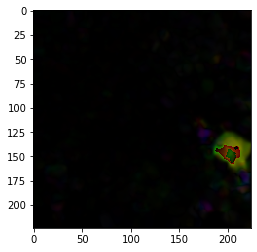

In [244]:
plt.imshow(avg_img_2)

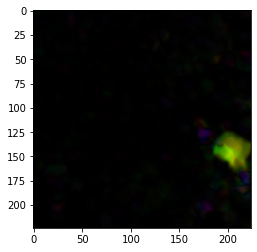

In [245]:
avg_img = np.array(np.round((flow_rgb_1/2) + (flow_rgb_2/2)), dtype=np.uint8)
plt.imshow(avg_img)

In [247]:
a = (flow_rgb_1/2) + (flow_rgb_2/2)

In [246]:
b = (flow_rgb_1 + flow_rgb_2) / 2

In [249]:
np.all(a == b)  # How?

False

In [251]:
flow_rgb_1.dtype  # This is why. So method 'a' is correct! 

dtype('uint8')

In [228]:
# Testing the integrated function.

In [229]:
avg_flow_image, flow_images = get_flow_rgb_images([frame1_name, frame2_name, frame3_name], flag=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

In [230]:
len(flow_images)

2

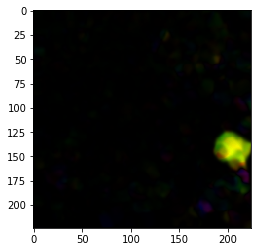

In [231]:
plt.imshow(flow_images[0])

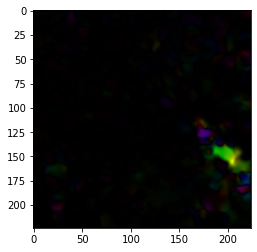

In [232]:
plt.imshow(flow_images[1])

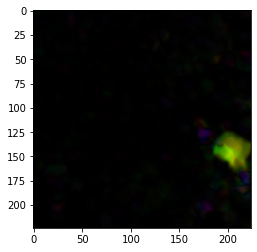

In [233]:
plt.imshow(avg_flow_image)

#### Testing Dence Optical Flow with different flags.

#### Type: 1

Time taken: 0.01


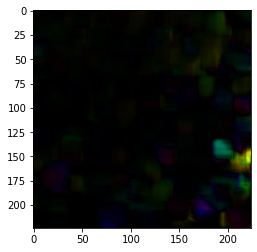

In [188]:
t1 = time.time()
flow_rgb_1 = _get_flow_rgb(frame1, frame2, flags=0)
t2 = time.time()
plt.imshow(flow_rgb_1)
print("Time taken: %.2f" % (t2 - t1))

Time taken: 0.01


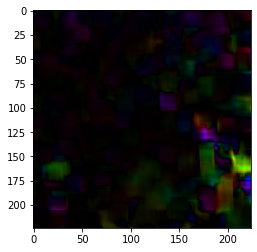

In [189]:
t1 = time.time()
flow_rgb_2 = _get_flow_rgb(frame2, frame3, flags=0)
t2 = time.time()
plt.imshow(flow_rgb_2)
print("Time taken: %.2f" % (t2 - t1))

#### Type 2.

In [191]:
t1 = time.time()
flow_rgb_1 = _get_flow_rgb(frame1, frame2, flags=cv2.OPTFLOW_USE_INITIAL_FLOW)
t2 = time.time()
plt.imshow(flow_rgb_1)
print("Time taken: %.2f" % (t2 - t1))

error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\video\src\optflowgf.cpp:1119: error: (-215:Assertion failed) _flow0.size() == prev0.size() && _flow0.channels() == 2 && _flow0.depth() == CV_32F in function 'cv::`anonymous-namespace'::FarnebackOpticalFlowImpl::calc'


In [ ]:
t1 = time.time()
flow_rgb_2 = _get_flow_rgb(frame2, frame3, flags=cv2.OPTFLOW_USE_INITIAL_FLOW)
t2 = time.time()
plt.imshow(flow_rgb_2)
print("Time taken: %.2f" % (t2 - t1))

#### Type 3.

Time taken: 0.01


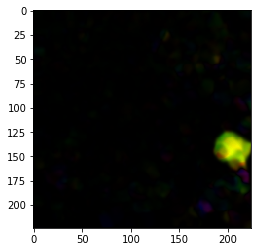

In [192]:
t1 = time.time()
flow_rgb_1 = _get_flow_rgb(frame1, frame2, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
t2 = time.time()
plt.imshow(flow_rgb_1)
print("Time taken: %.2f" % (t2 - t1))

Time taken: 0.01


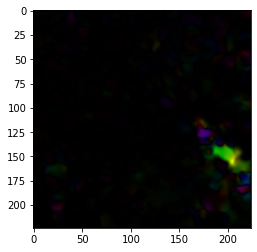

In [193]:
t1 = time.time()
flow_rgb_2 = _get_flow_rgb(frame2, frame3, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
t2 = time.time()
plt.imshow(flow_rgb_2)
print("Time taken: %.2f" % (t2 - t1))

### Testing Optical flow tutorial
```py
import cv2
import numpy as np
cap = cv2.VideoCapture("temp_optical_flow/vtest.avi")

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while(1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',rgb)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('temp_optical_flow/opticalfb.png',frame2)
        cv2.imwrite('temp_optical_flow/opticalhsv.png',rgb)
    prvs = next

cap.release()
cv2.destroyAllWindows()

```

In [175]:
cap = cv2.VideoCapture("temp_optical_flow/vtest.avi")

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

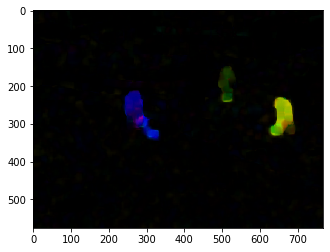

In [176]:
ret, frame2 = cap.read()
next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
plt.imshow(rgb)
prvs = next

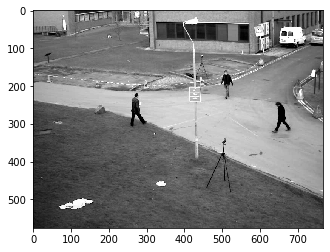

In [101]:
plt.imshow(prvs, cmap='gray')

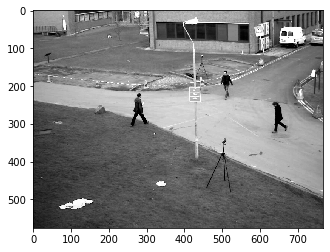

In [102]:
plt.imshow(next, cmap='gray')